# Pittsburgh “Best Neighborhood” – CSV-only Check-in Notebook

## 3) City Steps — count/sum by group & quick score

In [2]:
# --- CONFIG ---
CSV_PATH = "LOCAL_CITY_STEPS_CSV_PATH.csv"
GROUP_COL = "auto"  # "auto" | column name | None

OUT_DIR = Path("../outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 140

def zscore(s):
    s = pd.to_numeric(s, errors='coerce')
    mu, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or pd.isna(sd):
        return pd.Series(0, index=s.index)
    return (s - mu) / sd

def summarize_missing(df):
    miss = df.isna().mean().sort_values(ascending=False)
    return miss[miss > 0]


### Load & inspect

In [3]:
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), " Columns:", len(df.columns))
display(df.head(3))
print("\nDtypes:\n", df.dtypes)
print("\nMissingness (top):\n", summarize_missing(df).head(15))


Rows: 1134  Columns: 26


,_id,id,name,maintenance_responsibility,installed,material,length,number_of_steps,schools_count,school_score,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1,326501686,10 Wakefield St,3rd Division,NaN,Concrete,53.0,8.0,0.0,100.0,...,South Oakland,3.0,4,42003040900,3,4,4,2-11,40.430934,-79.957093
1,2,527853474,1005 St Martin St,4th Division,NaN,Concrete,33.0,24.0,NaN,NaN,...,South Side Slopes,3.0,17,42003170600,3,17,3,4-6,40.422418,-79.988218
2,3,1074700399,1017 St Martin St,4th Division,NaN,Concrete,52.0,4.0,NaN,NaN,...,South Side Slopes,3.0,17,42003170600,3,17,3,4-6,40.422479,-79.987608



Dtypes:
 _id                             int64
id                              int64
name                           object
maintenance_responsibility     object
installed                      object
material                       object
length                        float64
number_of_steps               float64
schools_count                 float64
school_score                  float64
total_population              float64
transit_rider_count           float64
transit_score                 float64
detour_score                  float64
overall_score                 float64
image                          object
neighborhood                   object
council_district              float64
ward                            int64
tract                           int64
public_works_division           int64
pli_division                    int64
police_zone                     int64
fire_zone                      object
latitude                      float64
longitude                     float64
dt

### Detect grouping column & compute step metrics

Using GROUP_COL: neighborhood


,group,steps_sum,steps_z
64,South Side Slopes,4795.0,5.996069
6,Beechview,2499.0,2.748145
53,Perry South,1927.0,1.938994
27,Elliott,1719.0,1.644757
32,Greenfield,1611.0,1.491980
46,Mount Washington,1586.0,1.456615
33,Hazelwood,1374.0,1.156719
42,Marshall-Shadeland,1373.0,1.155305
12,Brookline,1255.0,0.988382
73,Troy Hill,1231.0,0.954431


Saved: ..\outputs\city_steps_by_group.csv


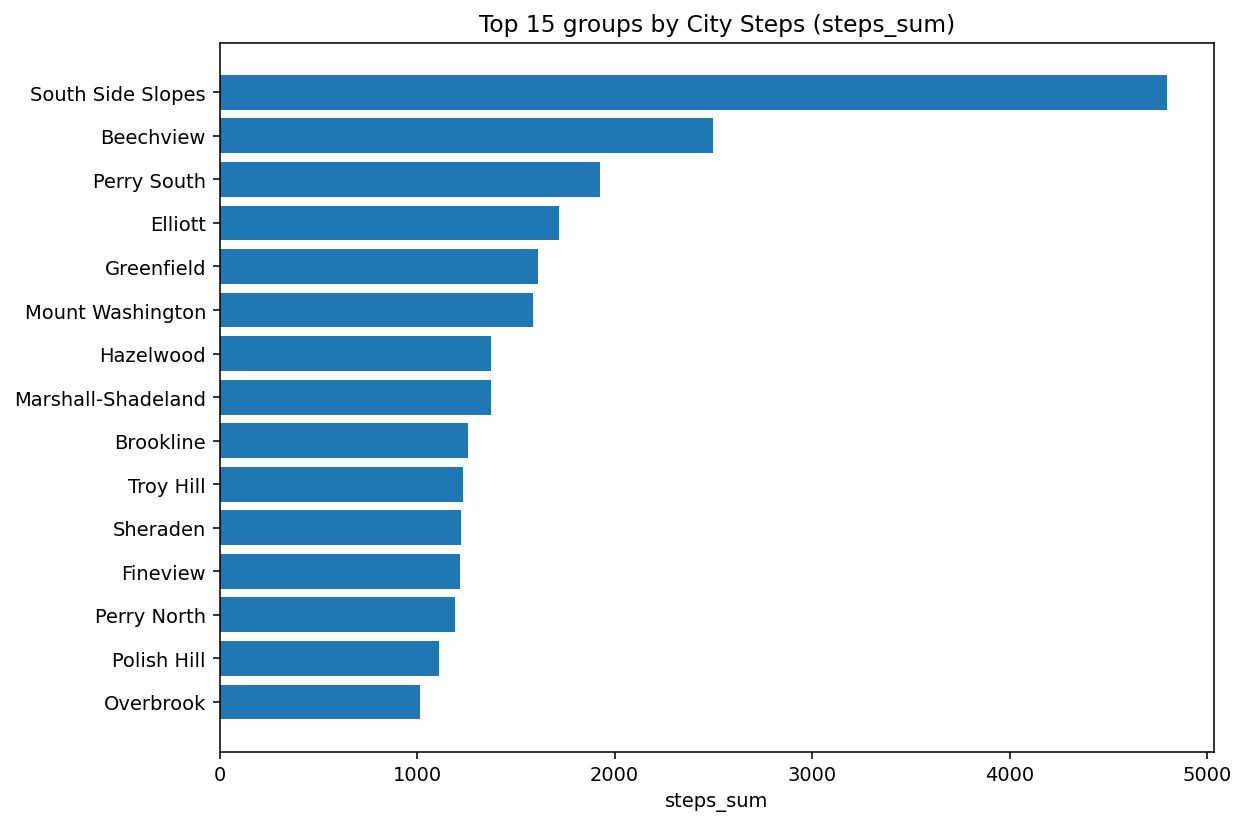

Saved figure: ..\figures\top15_city_steps.png


In [4]:
if GROUP_COL == "auto":
    prefs = ["neighborhood","zone","district","Neighborhood","Zone","District"]
    GROUP_COL = next((c for c in prefs if c in df.columns), None)
print("Using GROUP_COL:", GROUP_COL)

steps_col = next((c for c in ["number_of_steps","steps","NUM_STEPS"] if c in df.columns), None)
if steps_col:
    df[steps_col] = pd.to_numeric(df[steps_col], errors="coerce")

if GROUP_COL is not None and GROUP_COL in df.columns:
    if steps_col:
        agg = (df.groupby(GROUP_COL)[steps_col].sum()
               .rename("steps_sum").reset_index()
               .rename(columns={GROUP_COL:"group"}))
        agg["steps_z"] = zscore(agg["steps_sum"])
    else:
        agg = (df.groupby(GROUP_COL).size()
               .rename("steps_count").reset_index()
               .rename(columns={GROUP_COL:"group"}))
        agg["steps_z"] = zscore(agg["steps_count"])
    agg = agg.sort_values("steps_z", ascending=False)
    display(agg.head(10))

    out_csv = OUT_DIR / "city_steps_by_group.csv"
    agg.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # Plot
    metric = "steps_sum" if "steps_sum" in agg.columns else "steps_count"
    top = agg.sort_values(metric, ascending=False).head(15)
    plt.figure(figsize=(9,6))
    plt.barh(top["group"], top[metric])
    plt.gca().invert_yaxis()
    plt.title(f"Top 15 groups by City Steps ({metric})")
    plt.xlabel(metric)
    plt.tight_layout()
    fig_path = FIG_DIR / "top15_city_steps.png"
    plt.savefig(fig_path, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved figure:", fig_path)
else:
    print("No grouping column found. You can still compute overall summaries:")
    if steps_col:
        print(df[steps_col].describe())
    else:
        print("No step count column found. Consider using segment counts or add neighborhoods via spatial join later.")
